# Transformer Model #
This notebook contains all the code need to train and evaluate our transformer model. Double check that you have the transformer.py file is in the same directory as this notebook along with the 3 datasets in the data folder. Run the cells in this notebook one by one.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformer import Transformer
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
tweet_df = pd.read_csv("./data/training.1600000.processed.noemoticon.csv/training.1600000.processed.noemoticon.csv", names=["target", "id", "date", "flag", "user", "text"], encoding="ansi")
tweet_df["target"] = np.where(tweet_df["target"] != 4, 0, 1)
print(tweet_df)

         target          id                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       1  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       1  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       1  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       1  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       1  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww

In [3]:
chatgpt_df = pd.read_csv("./data/chatGPTsentiment/file.csv", names=["id","text","target"])

chatgpt_df = chatgpt_df.loc[chatgpt_df["target"] != "neutral"]
chatgpt_df["target"] = np.where(chatgpt_df["target"]=="good", 1,0)
chatgpt_df = chatgpt_df[1:]
print(chatgpt_df)

              id                                               text  target
2            1.0  Try talking with ChatGPT, our new AI system wh...       1
4            3.0  THRILLED to share that ChatGPT, our new model ...       1
5            4.0  As of 2 minutes ago, @OpenAI released their ne...       0
6            5.0  Just launched ChatGPT, our new AI system which...       1
7            6.0  As of 2 minutes ago, @OpenAI released their ne...       0
...          ...                                                ...     ...
219288  219287.0  One of my new favorite thing to do with #ChatG...       1
219290  219289.0  Other Software Projects Are Now Trying to Repl...       0
219291  219290.0  I asked #ChatGPT to write a #NYE Joke for SEOs...       1
219292  219291.0  chatgpt is being disassembled until it can onl...       0
219293  219292.0  2023 predictions by #chatGPT. Nothing really s...       0

[163807 rows x 3 columns]


In [4]:
financial_df = pd.read_csv("./data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt", names=["text","target"], encoding="windows-1252", header=None, delimiter="@")

financial_df = financial_df.loc[financial_df["target"] != "neutral"]
financial_df["target"] = np.where(financial_df["target"]=="positive", 1,0)
print(financial_df)

                                                   text  target
2     The international electronic industry company ...       0
3     With the new production plant the company woul...       1
4     According to the company 's updated strategy f...       1
5     FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...       1
6     For the last quarter of 2010 , Componenta 's n...       1
...                                                 ...     ...
4840  HELSINKI Thomson Financial - Shares in Cargote...       0
4841  LONDON MarketWatch -- Share prices ended lower...       0
4843  Operating profit fell to EUR 35.4 mn from EUR ...       0
4844  Net sales of the Paper segment decreased to EU...       0
4845  Sales in Finland decreased by 10.5 % in Januar...       0

[1967 rows x 2 columns]


# Train and Test Set #
We will take 1% of the twitter data set and create a train and test set from it.

In [5]:
PERCENT_OF_DATASET = 0.01

In [6]:
sample = tweet_df.sample(frac=PERCENT_OF_DATASET, random_state=1234)

tweet_train = sample[:int(sample.shape[0]*0.8)]
tweet_test = sample[-int(sample.shape[0]*0.2):]

sample = chatgpt_df.sample(frac=PERCENT_OF_DATASET, random_state=1234)

chatgpt_test = sample

print(tweet_train.shape)
print(tweet_test.shape)

(12800, 6)
(3200, 6)


# Tokenization #

In [7]:
import nltk

In [8]:
NGRAM = 1 # The ngram language model you want to train

In [9]:
train_text = tweet_train["text"]
test_text = tweet_test["text"]
chatgpt_text = chatgpt_test["text"]
financial_text = financial_df["text"]

nltk.download('punkt')

SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"

def tokenize_line(line: str, ngram: int,
                   sentence_begin: str=SENTENCE_BEGIN,
                   sentence_end: str=SENTENCE_END):
  """
  Tokenize a single string. Glue on the appropriate number of
  sentence begin tokens and sentence end tokens (ngram - 1), except
  for the case when ngram == 1, when there will be one sentence begin
  and one sentence end token.
  Args:
    line (str): text to tokenize
    ngram (int): ngram preparation number
    sentence_begin (str): sentence begin token value
    sentence_end (str): sentence end token value

  Returns:
    list of strings - a single line tokenized
  """
  inner_pieces = nltk.word_tokenize(line)

  if ngram == 1:
    tokens = [sentence_begin] + inner_pieces + [sentence_end]
  else:
    tokens = ([sentence_begin] * (ngram - 1)) + inner_pieces + ([sentence_end] * (ngram - 1))

  return tokens


train_data=[]
test_data=[]
chatgpt_data=[]
financial_data=[]

for index in train_text.index:
    train_data.append(tokenize_line(train_text.loc[index].lower(), NGRAM))

for index in test_text.index:
    test_data.append(tokenize_line(test_text.loc[index].lower(), NGRAM))

for index in chatgpt_text.index:
    chatgpt_data.append(tokenize_line(chatgpt_text.loc[index].lower(), NGRAM))

for index in financial_text.index:
    financial_data.append(tokenize_line(financial_text.loc[index].lower(), NGRAM))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jjlnb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Training Setup #
We set up the different generators for each of our datasets.

In [10]:
from keras.preprocessing.text import Tokenizer

In [11]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_data)

words_encoded_train = word_tokenizer.texts_to_sequences(train_data)
words_encoded_test = word_tokenizer.texts_to_sequences(test_data)
chatgpt_encoded = word_tokenizer.texts_to_sequences(chatgpt_data)
financial_encoded = word_tokenizer.texts_to_sequences(financial_data)

In [12]:
train_X = words_encoded_train
train_Y = tweet_train["target"]

test_X = words_encoded_test
test_Y = tweet_test["target"]

chatgpt_X = chatgpt_encoded
chatgpt_Y = chatgpt_test["target"]

financial_X = financial_encoded
financial_Y = financial_df["target"]

In [13]:
num_sequences_per_batch = 64
src_vocab_size = len(word_tokenizer.index_word)+1
max_seq_length = 100

In [14]:
def data_generator(X, Y, num_sequences_per_batch=64):
    """
    Data generator that yields pairings of datapoints and labels in batches of size num_sequences_per_batch.
    :param X: The datapoints
    :param Y: The labels
    :param num_sequences_per_batch: The number of batches to yield
    :return:
    """
    total_batches = len(X) // num_sequences_per_batch

    while True:
        batch_count = 0

        pad = lambda a : a[0:max_seq_length] if len(a) > max_seq_length else a + [2] * (max_seq_length-len(a))

        while batch_count < total_batches:

            padded_sequences = []
            for sequence in X[batch_count*num_sequences_per_batch:(batch_count+1)*num_sequences_per_batch]:
                padded_sequences += [pad(sequence)]

            yield torch.from_numpy(np.array(padded_sequences, dtype=int)), torch.from_numpy(np.array(Y[batch_count*num_sequences_per_batch:(batch_count+1)*num_sequences_per_batch], dtype=float))
            batch_count+=1



In [15]:
train_generator = data_generator(train_X, train_Y)
test_generator = data_generator(test_X, test_Y)

chatgpt_generator = data_generator(chatgpt_X, chatgpt_Y)
financial_generator = data_generator(financial_X, financial_Y)



# Baseline #
Using sklearn's Logistic Regression model, we train a model on the tweets training set and then evaluate it on the remaining datasets.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
def featurize_counts(X, num_tokens = 10000):
    """
    Featurizes each datapoint as an array of the counts of each token. Only takes into account the first num_tokens.
    :param X:
    :param num_tokens:
    :return:
    """

    pad = lambda a : a[0:max_seq_length] if len(a) > max_seq_length else a + [2] * (max_seq_length-len(a))

    padded_sequences = []
    for sequence in X:
        padded_sequences += [pad(sequence)]

    arr = np.array(padded_sequences)

    counts = np.asarray([[0] * num_tokens] * len(arr))

    for i in range(counts.shape[1]):
        counts[:, i] = np.sum(np.where(arr == i, 1, 0), axis=1)

    return np.array(counts)




In [18]:
tweet_train_counts = featurize_counts(train_X)
tweet_test_counts = featurize_counts(test_X)
chatgpt_counts = featurize_counts(chatgpt_X)
financial_counts = featurize_counts(financial_X)


In [19]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

log_reg.fit(tweet_train_counts, train_Y)

train_accuracy = log_reg.score(tweet_train_counts, train_Y)
test_accuracy = log_reg.score(tweet_test_counts, test_Y)

chatgpt_accuracy = log_reg.score(chatgpt_counts, chatgpt_Y)
financial_accuracy = log_reg.score(financial_counts, financial_Y)

print(f"Tweet Train Accuracy: {train_accuracy}")
print(f"Tweet Test Accuracy: {test_accuracy}")
print(f"ChatGPT Accuracy: {chatgpt_accuracy}")
print(f"Financial Accuracy: {financial_accuracy}")

Tweet Train Accuracy: 0.897421875
Tweet Test Accuracy: 0.7584375
ChatGPT Accuracy: 0.47435897435897434
Financial Accuracy: 0.6329435688866294


# Training the Transformer #
Initializes the transformer and trains it on the train set for 100 epochs. Model weights are then saved to a file where they can be loaded from at a later point.

In [20]:
MODEL_SAVE_FILE = "model_file"
MODEL_LOAD_FILE = "100epoch" # Change this to load a previously trained model

In [21]:
d_model = 52
num_heads = 4
num_layers = 4
d_ff = 128

In [16]:
model = Transformer(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

model.train()

losses = []
accuracy = []

true_positive = []
false_positive = []
true_negative = []
false_negative = []

for epoch in range(100):
    model.train()
    loss_total = 0
    for i in range(len(train_X) // num_sequences_per_batch):
        src_data, tgt_data = next(train_generator)
        optimizer.zero_grad()
        output = model(src_data)
        loss = criterion(output.contiguous().view(-1), tgt_data.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    model.eval()
    y_pred = np.array([])

    for i in range(len(train_X) // num_sequences_per_batch):
        src_data, tgt_data = next(train_generator)

        pred = model.forward(torch.from_numpy((np.array(src_data, dtype=int))))
        pred = np.where(pred.contiguous().view(-1) > 0.5, 1, 0)
        y_pred = np.concatenate((y_pred, pred))

    accuracy += [np.sum(np.where(y_pred == train_Y, 1, 0)) / len(train_Y)]
    true_positive += [np.sum(np.where(y_pred == train_Y, 1, 0) * np.where(train_Y == 1, 1, 0))]
    false_positive += [np.sum(np.where(y_pred != train_Y, 1, 0) * np.where(train_Y == 0, 1, 0))]
    true_negative += [np.sum(np.where(y_pred == train_Y, 1, 0) * np.where(train_Y == 0, 1, 0))]
    false_negative += [np.sum(np.where(y_pred != train_Y, 1, 0) * np.where(train_Y == 1, 1, 0))]
    losses += [loss_total / num_sequences_per_batch]

    print(f"Epoch: {epoch+1}, Loss: {loss_total / num_sequences_per_batch}")


torch.save(model.state_dict(), MODEL_SAVE_FILE)

Epoch: 1, Loss: 417.38681510463357
Epoch: 2, Loss: 416.0613031089306
Epoch: 3, Loss: 415.1883968412876
Epoch: 4, Loss: 414.3641142435372
Epoch: 5, Loss: 413.56775603815913
Epoch: 6, Loss: 412.829823166132
Epoch: 7, Loss: 412.1891930960119
Epoch: 8, Loss: 411.6264988258481
Epoch: 9, Loss: 411.11192544549704
Epoch: 10, Loss: 410.62916311994195
Epoch: 11, Loss: 410.1692468300462
Epoch: 12, Loss: 409.72696144133806
Epoch: 13, Loss: 409.2981412783265
Epoch: 14, Loss: 408.87981412932277
Epoch: 15, Loss: 408.46972696483135
Epoch: 16, Loss: 408.06578831374645
Epoch: 17, Loss: 407.6669303290546
Epoch: 18, Loss: 407.2728947289288
Epoch: 19, Loss: 406.88328360021114
Epoch: 20, Loss: 406.4979512952268
Epoch: 21, Loss: 406.1165746450424
Epoch: 22, Loss: 405.7385733090341
Epoch: 23, Loss: 405.3637406229973
Epoch: 24, Loss: 404.99174650758505
Epoch: 25, Loss: 404.62253419682384
Epoch: 26, Loss: 404.25608991086483
Epoch: 27, Loss: 403.8922262750566
Epoch: 28, Loss: 403.53125346824527
Epoch: 29, Loss: 

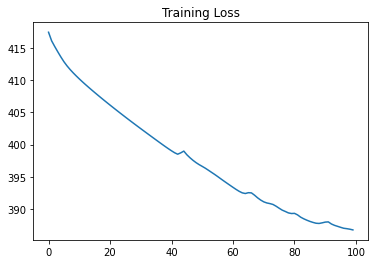

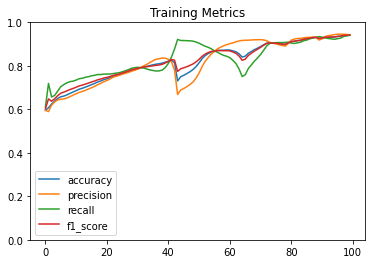

In [20]:

plt.plot([i for i in range(len(losses))], losses)
plt.title("Training Loss")
plt.show()

recall = [true_positive[i]/(true_positive[i] + false_negative[i]) for i in range(len(true_positive))]
precision = [true_positive[i]/(true_positive[i] + false_positive[i]) for i in range(len(true_positive))]
f1 = [2 * (recall[i] * precision[i])/(recall[i] + precision[i]) for i in range(len(recall))]

plt.title("Training Metrics")
plt.plot([i for i in range(len(accuracy))], accuracy, label='accuracy')
plt.plot([i for i in range(len(precision))], precision, label='precision')
plt.plot([i for i in range(len(recall))], recall, label='recall')
plt.plot([i for i in range(len(f1))], f1, label='f1_score')
plt.legend()
plt.ylim(0,1)
plt.show()


In [22]:
model = Transformer(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length)
model.load_state_dict(torch.load(MODEL_LOAD_FILE))

model.eval()

y_pred = np.array([])
train_generator = data_generator(train_X, train_Y)

for i in range(len(train_X) // num_sequences_per_batch):
        src_data, tgt_data = next(train_generator)

        pred = model.forward(torch.from_numpy((np.array(src_data, dtype=int))))
        pred = np.where(pred.contiguous().view(-1) > 0.5, 1, 0)
        y_pred = np.concatenate((y_pred, pred))

train_accuracy = np.sum(np.where(y_pred == train_Y, 1, 0)) / len(train_Y)
true_positive = np.sum(np.where(y_pred == train_Y, 1, 0) * np.where(train_Y == 1, 1, 0))
false_positive = np.sum(np.where(y_pred != train_Y, 1, 0) * np.where(train_Y == 0, 1, 0))
true_negative = np.sum(np.where(y_pred == train_Y, 1, 0) * np.where(train_Y == 0, 1, 0))
false_negative = np.sum(np.where(y_pred != train_Y, 1, 0) * np.where(train_Y == 1, 1, 0))

recall = true_positive/(true_positive + false_negative)
precision = true_positive/(true_positive + false_positive)
f1 = 2 * (recall * precision)/(recall + precision)

print(f"Train accuracy: {train_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Train accuracy: 0.929140625
Precision: 0.9458064516129032
Recall: 0.9112665112665113
F1: 0.9282152750296795


# Evaluating the Model #
Evaluates the model's performance on the test tweets, the ChatGPT dataset, and the financial dataset.

## Tweet Sentiment (Test Set) ##


In [23]:
model = Transformer(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length)
model.load_state_dict(torch.load(MODEL_LOAD_FILE))

model.eval()

y_pred = np.array([])

for i in range(len(test_X) // num_sequences_per_batch):
        src_data, tgt_data = next(test_generator)

        pred = model.forward(torch.from_numpy((np.array(src_data, dtype=int))))
        pred = np.where(pred.contiguous().view(-1) > 0.5, 1, 0)
        y_pred = np.concatenate((y_pred, pred))

test_accuracy = np.sum(np.where(y_pred == test_Y, 1, 0)) / len(test_Y)
true_positive = np.sum(np.where(y_pred == test_Y, 1, 0) * np.where(test_Y == 1, 1, 0))
false_positive = np.sum(np.where(y_pred != test_Y, 1, 0) * np.where(test_Y == 0, 1, 0))
true_negative = np.sum(np.where(y_pred == test_Y, 1, 0) * np.where(test_Y == 0, 1, 0))
false_negative = np.sum(np.where(y_pred != test_Y, 1, 0) * np.where(test_Y == 1, 1, 0))

recall = true_positive/(true_positive + false_negative)
precision = true_positive/(true_positive + false_positive)
f1 = 2 * (recall * precision)/(recall + precision)

print(f"Test accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Test accuracy: 0.6578125
Precision: 0.6990068754774638
Recall: 0.5662128712871287
F1: 0.6256410256410257


## ChatGPT Tweet Sentiment ##

In [24]:
y_pred = np.array([])

for i in range(len(chatgpt_Y) // num_sequences_per_batch):
        src_data, tgt_data = next(chatgpt_generator)

        pred = model.forward(torch.from_numpy((np.array(src_data, dtype=int))))
        pred = np.where(pred.contiguous().view(-1) > 0.5, 1, 0)
        y_pred = np.concatenate((y_pred, pred))


adjusted_y = chatgpt_Y[:(len(chatgpt_Y) // num_sequences_per_batch) * num_sequences_per_batch]
test_accuracy = np.sum(np.where(y_pred == adjusted_y, 1, 0)) / len(adjusted_y)
true_positive = np.sum(np.where(y_pred == adjusted_y, 1, 0) * np.where(adjusted_y == 1, 1, 0))
false_positive = np.sum(np.where(y_pred != adjusted_y, 1, 0) * np.where(adjusted_y == 0, 1, 0))
true_negative = np.sum(np.where(y_pred == adjusted_y, 1, 0) * np.where(adjusted_y == 0, 1, 0))
false_negative = np.sum(np.where(y_pred != adjusted_y, 1, 0) * np.where(adjusted_y == 1, 1, 0))

recall = true_positive/(true_positive + false_negative)
precision = true_positive/(true_positive + false_positive)
f1 = 2 * (recall * precision)/(recall + precision)

print(f"Test accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Test accuracy: 0.516875
Precision: 0.3367198838896952
Recall: 0.4233576642335766
F1: 0.37510105092966856


## Finacial Phrasebook ##

In [25]:
y_pred = np.array([])

for i in range(len(financial_Y) // num_sequences_per_batch):
        src_data, tgt_data = next(financial_generator)

        pred = model.forward(torch.from_numpy((np.array(src_data, dtype=int))))
        pred = np.where(pred.contiguous().view(-1) > 0.5, 1, 0)
        y_pred = np.concatenate((y_pred, pred))

adjusted_y = financial_Y[:(len(financial_Y) // num_sequences_per_batch) * num_sequences_per_batch]
test_accuracy = np.sum(np.where(y_pred == adjusted_y, 1, 0)) / len(adjusted_y)
true_positive = np.sum(np.where(y_pred == adjusted_y, 1, 0) * np.where(adjusted_y == 1, 1, 0))
false_positive = np.sum(np.where(y_pred != adjusted_y, 1, 0) * np.where(adjusted_y == 0, 1, 0))
true_negative = np.sum(np.where(y_pred == adjusted_y, 1, 0) * np.where(adjusted_y == 0, 1, 0))
false_negative = np.sum(np.where(y_pred != adjusted_y, 1, 0) * np.where(adjusted_y == 1, 1, 0))

recall = true_positive/(true_positive + false_negative)
precision = true_positive/(true_positive + false_positive)
f1 = 2 * (recall * precision)/(recall + precision)

print(f"Test accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Test accuracy: 0.4375
Precision: 0.7397260273972602
Recall: 0.3176470588235294
F1: 0.44444444444444436
